### GraphSVX

Here we visualize the explainer results and analyze specific graph theoretic properties for datatset ```syn5```

In [1]:
# imports
import os
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
results = '../results/node_masks/'
# Load produced masks
dirs = os.listdir(results)
len(dirs)

180

In [3]:
# Get the masks
node_masks = []
# This would print all the files and directories
for file in dirs:
    # Check if file extension is ".npy" which are
    # numpy binary files to represent large data
    if file.split('.')[-1] == 'npy' and file.split('_')[2] == 'syn5':
        # print(file)
        node_masks.append(file)
len(node_masks)

60

In [4]:
masked_subgraph = '../results/exp_mask_adj/'

# Load produced masks
dirs = os.listdir(masked_subgraph)
dirs[120]

'masked_adj_syn5_explain_node_400.npy'

In [5]:
# Get the masks
mask_adj = []
# This would print all the files and directories
for file in dirs:
    # Check if file extension is ".npy" which are
    # numpy binary files to represent large data
    if file.split('.')[-1] == 'npy' and file.split('_')[2] == 'syn5':
        # print(file)
        mask_adj.append(file)
len(mask_adj)

60

In [6]:
def show_adjacency_full(path,mask):
    """Obtain the numpy array of the mask

    Args:
        mask (str): Filename containing the mask
        ax (Axes class object, optional): Axis. Defaults to None.

    Returns:
        numpy array: Numpy array version of the mask
    """
    # Obtain mask as array from the filename sent in var "mask"
    adj = np.load(os.path.join(path, mask), allow_pickle=True)

    return adj

### Analyzing Graph Properties

Here we measure the following quantities:

- Nodes: |V|
- Edges: |E|
- Avg degree
- Diameter of the graph
- Sparsity measure: edge density = |E|/C(|V|,2)
- Node Betweenness centrality

In [7]:
# Get data adjacency matrix
datadir = '../results/dataset_matrix/'
matrices = os.listdir(datadir)
matrices

['adj_matrix_syn1.npy', 'adj_matrix_syn2.npy', 'adj_matrix_syn5.npy']

In [8]:
data = []
dataset = 'syn5.npy'
# This would print all the files and directories
for file in matrices:
    # Check if file extension is ".npy" which are
    # numpy binary files to represent large data
    if file.split('.')[-1] == 'npy' and file.split('_')[2] == dataset:
        data.append(file)
data

['adj_matrix_syn5.npy']

In [9]:
adj_matrix = np.load(os.path.join(datadir, data[0]), allow_pickle=True)
adj_matrix.shape

(1231, 1231)

In [10]:
def normalize(A):
    scale_factor = A.max() - A.min()
    B = np.ones_like(A)*A.min()

    A = (A - B)/scale_factor
    return A

def centrality(dataset_G,nodes,mask,node_to_explain):
    
    sources = [node_to_explain]
    targets = [v for v in nodes if v!=node_to_explain]
    bc = nx.betweenness_centrality_subset(dataset_G,sources,targets)

    # By explainer
    A = mask.copy()
    
    # Importance from bc
    B = np.zeros_like(A)
    for v in list(bc.keys()):
        B[v] = bc.get(v)
    
    A1 = normalize(A)
    B1 = normalize(B)

    if(np.array_equal(A1,B1) == False):
        return 1/(np.linalg.norm(A1 - B1, 2)**2)
    else:
        return 1

def graph_prop(dataset_G,graph,mask,node_to_explain):

    v = graph.number_of_nodes()
    e = graph.number_of_edges()
    avg_degree = float('%.3f'%(2*e/v))
    # diameter = nx.diameter(graph)
    compact_diam = 0
    # Usually if multiple components, diam = inf
    # But since we are using the diameter as a measure of compactness
    # we measure it as avg of diameter of components - verify with devendra once
    for g in list(nx.connected_components(graph)):
        compact_diam += nx.diameter(graph.subgraph(g))
    compact_diam /= nx.number_connected_components(graph)
    sparsity = float('%.3f'%(2*e/(v*(v-1))))
    coh = centrality(dataset_G,list(graph.nodes()),mask,node_to_explain)

    return [v,e,avg_degree,compact_diam,sparsity,coh]

In [11]:
def get_node_to_explain(filename):

    required_slice = filename.split('_')[-1]
    node = int(required_slice.split('.')[0])

    return node

In [12]:
graph_properties = []
dataset_G = nx.from_numpy_array(adj_matrix)

# len(mask_adj)
for i in range(len(mask_adj)):
    # adj = show_adjacency_full(masked_subgraph,mask_adj[i])  # Get the adjacency matrix of the explanation
    # G = nx.from_numpy_array(adj)    # Get the explanation subgraph
    node_mask = show_adjacency_full(results, node_masks[i])  # Get the node mask for the considered explanation
    idxs = np.where(node_mask != 0)[0]
    G = nx.induced_subgraph(dataset_G, idxs)
    node_to_explain = get_node_to_explain(mask_adj[i])  # Get the label of the node being explained
    
    print(f"Analyzing graph properties for explanation of node #{node_to_explain}")
    graph_properties.append(graph_prop(dataset_G,G,node_mask,node_to_explain))

print("All explanations successfully analyzed!")

Analyzing graph properties for explanation of node #400
Analyzing graph properties for explanation of node #405
Analyzing graph properties for explanation of node #410
Analyzing graph properties for explanation of node #415
Analyzing graph properties for explanation of node #420
Analyzing graph properties for explanation of node #425
Analyzing graph properties for explanation of node #430
Analyzing graph properties for explanation of node #435
Analyzing graph properties for explanation of node #440
Analyzing graph properties for explanation of node #445
Analyzing graph properties for explanation of node #450
Analyzing graph properties for explanation of node #455
Analyzing graph properties for explanation of node #460
Analyzing graph properties for explanation of node #465
Analyzing graph properties for explanation of node #470
Analyzing graph properties for explanation of node #475
Analyzing graph properties for explanation of node #480
Analyzing graph properties for explanation of no

In [13]:
# Convert the above data into a data frame
import pandas as pd
df = pd.DataFrame(graph_properties, columns=["Order","Size","Average Degree","Diameter","Sparsity","Coherence"])

df.describe()

,Order,Size,Average Degree,Diameter,Sparsity,Coherence
count,60.000000,60.000000,60.000000,60.000000,60.000000,60.000000
mean,14.433333,14.666667,1.978267,4.443056,0.197383,1.044991
std,7.574190,8.319197,0.223857,1.162471,0.100869,1.644529
min,5.000000,4.000000,1.600000,3.000000,0.062000,0.006492
25%,9.000000,8.750000,1.778000,4.000000,0.108750,0.053700
50%,13.000000,13.500000,2.000000,4.000000,0.172000,0.110376
75%,20.250000,20.500000,2.155500,5.000000,0.278000,1.690345
max,36.000000,39.000000,2.364000,9.000000,0.400000,5.496778


In [14]:
# Save the dataframe as a csv for later use
df.to_csv("syn5.csv")

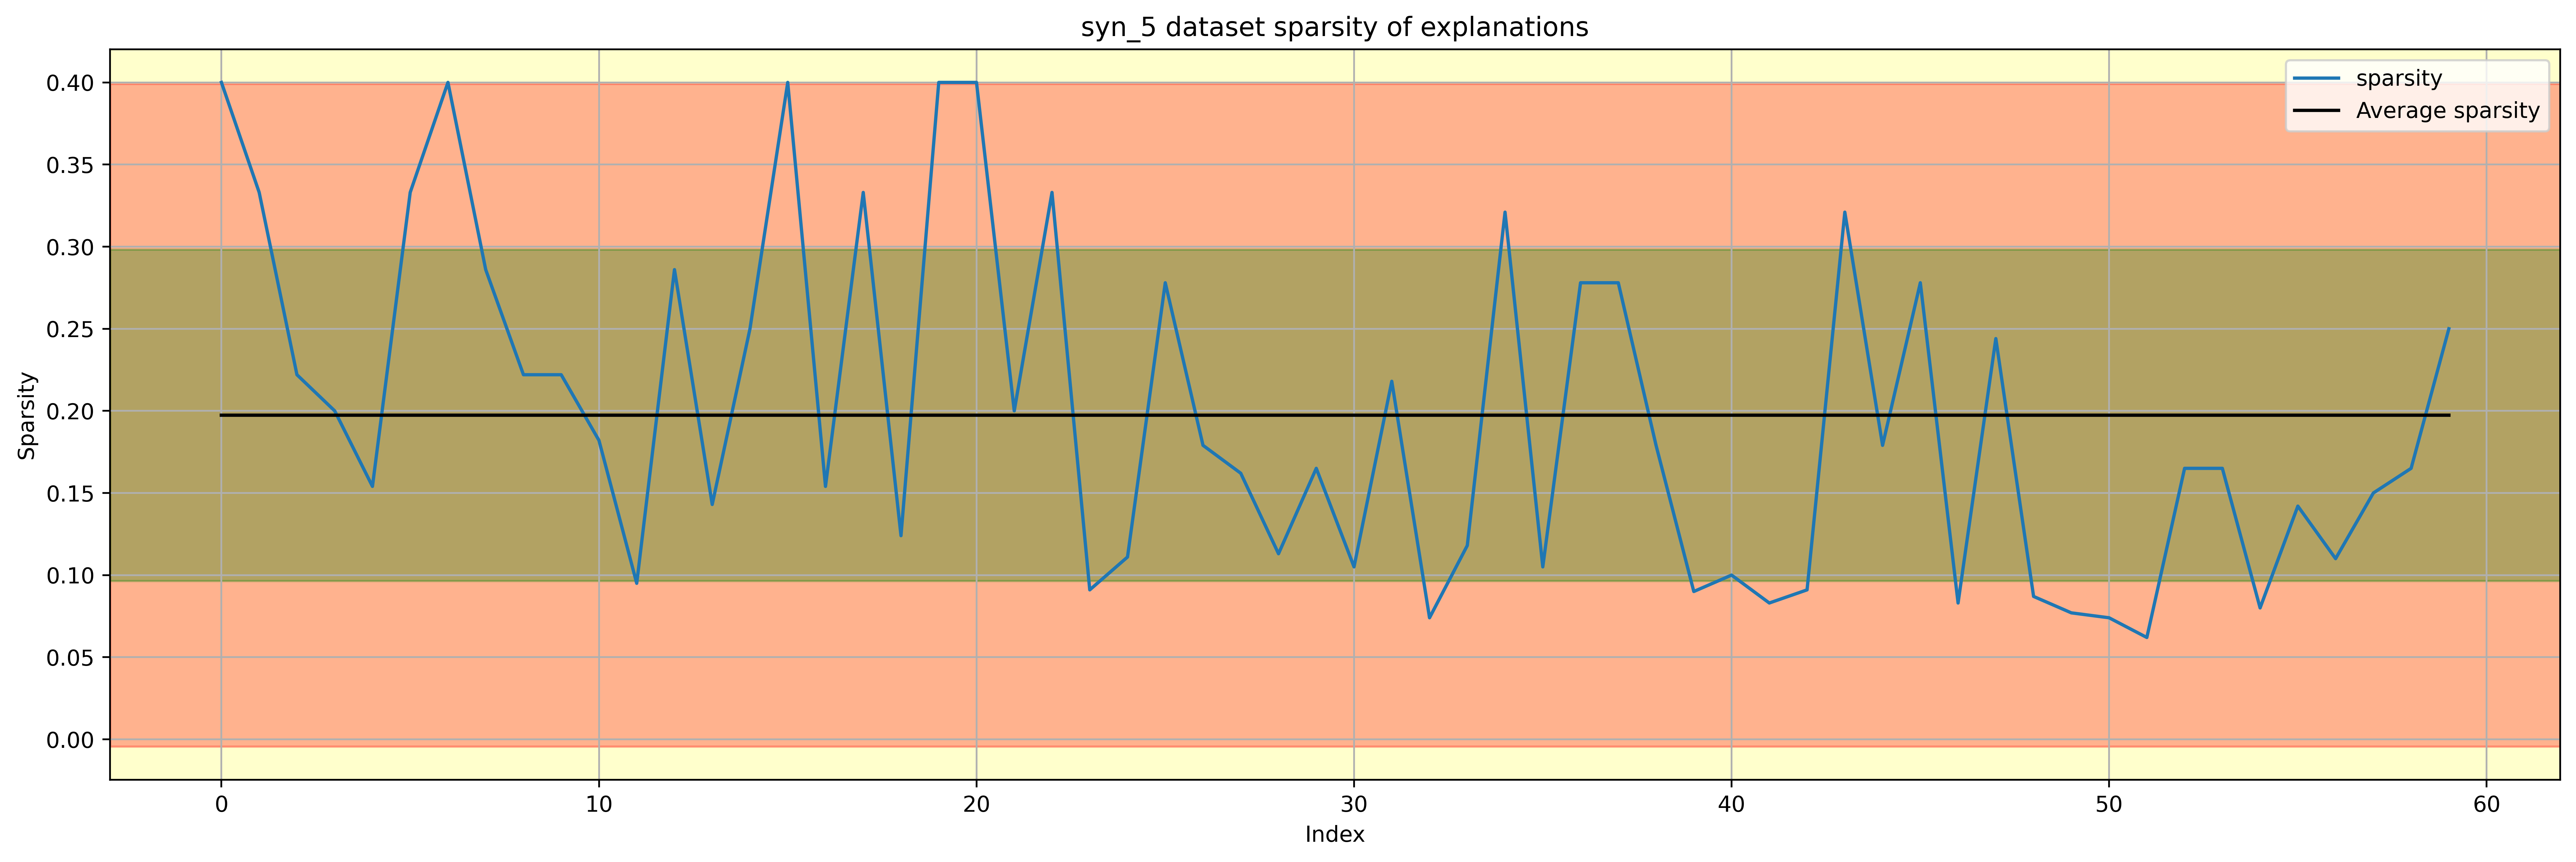

In [15]:
# Plot Sparsity
x = list(range(len(df)))
sparse = list(df['Sparsity'])
def_sparse = list(np.ones(len(df))*0.5)
mean_sparse = list(np.ones(len(df))*df['Sparsity'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, sparse, label='sparsity')
# plt.plot(x,def_sparse, label = 'Max edge density for sparse graphs')
plt.plot(x,mean_sparse, label = 'Average sparsity', color='k')

sp_mean = df['Sparsity'].mean()
sp_std = df['Sparsity'].std()
y1 = sp_mean - sp_std
y_1 = y1 - sp_std
y2 = sp_mean + sp_std
y_2 = y2 + sp_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_5 dataset sparsity of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Sparsity")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\GraphSVX_graph_properties\graph_theoretic_properties\plots\syn5_sparsity")
plt.show()

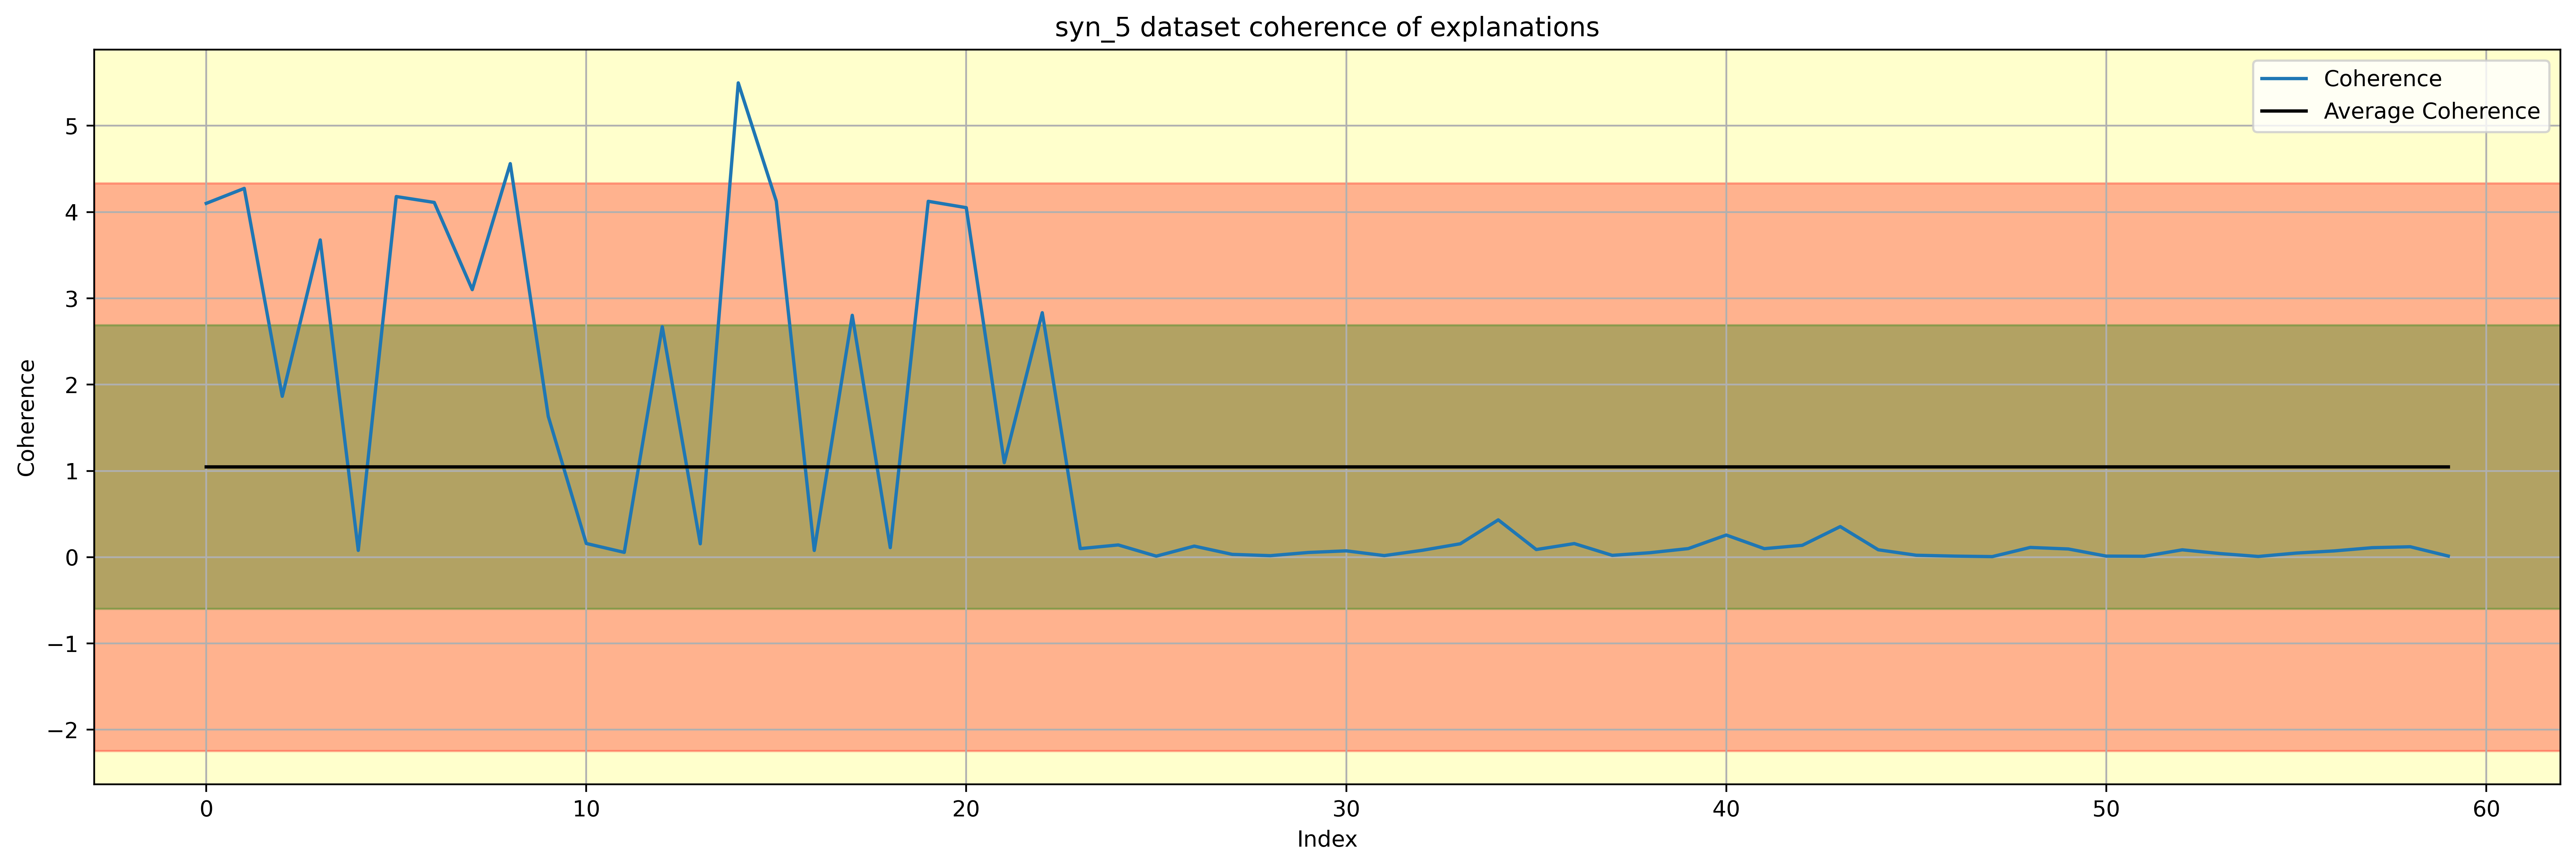

In [16]:
# Plot Coherence
x = list(range(len(df)))
coh = list(df['Coherence'])
def_coh = list(np.ones(len(df))*0.5)
mean_coh = list(np.ones(len(df))*df['Coherence'].mean())
plt.figure(figsize=(20,6), dpi = 500)
plt.gca().grid(True)
plt.gca().set_facecolor((1, 1, 0.8))
plt.plot(x, coh, label='Coherence')
# plt.plot(x,def_sparse, label = 'Max edge density for sparse graphs')
plt.plot(x,mean_coh, label = 'Average Coherence', color='k')

sp_mean = df['Coherence'].mean()
sp_std = df['Coherence'].std()
y1 = sp_mean - sp_std
y_1 = y1 - sp_std
y2 = sp_mean + sp_std
y_2 = y2 + sp_std
plt.axhspan(y_1, y_2, color='red', alpha=0.3)
plt.axhspan(y1, y2, color='green', alpha=0.3)

plt.title('syn_5 dataset coherence of explanations', fontsize=12)
plt.legend(prop={'size':10})
plt.ylabel("Coherence")
plt.xlabel("Index")
plt.savefig(fname= "D:\D_Drive\Github\Thesis\GraphSVX_graph_properties\graph_theoretic_properties\plots\syn5_coherence")
plt.show()